## Imports

In [298]:
import argparse
import os
import copy

import numpy as np
import h5py
import PIL.Image as pil_image
from PIL import Image
import argparse
import glob 
import math

import torch
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from tqdm import tqdm

## Pre processing

As imagens do dataset tem tamanhos diferentes e as redes neurais recebem tamanhos fixos de imagens. Qual é o resize que miniza a perda de qualidade das imagens? Gerar um fráfico e ver como esses valores estão distribuídos.

A media dos valores de pixels é: 264 x 204


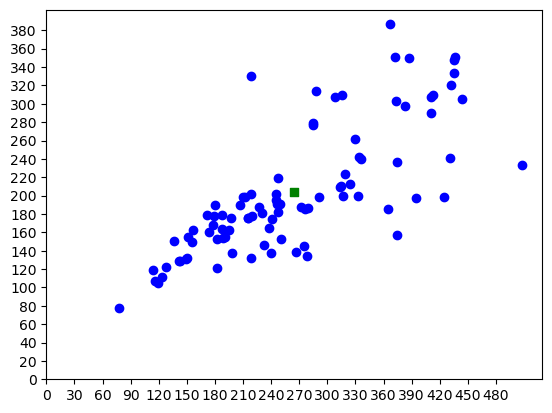

In [299]:
imagesPath = 'C:/Users/moreiran/Desktop/FSRCNN/FSRCNN/T91'

xs = []
ys = []

for _, _, files in os.walk(imagesPath):
  for file in files:
    image = Image.open(os.path.join(imagesPath, file))
    x, y = image.size
    xs.append(x)
    ys.append(y)

x_media = np.sum(xs) / len(xs)
y_media = np.sum(ys) / len(ys)

plt.scatter(xs, ys, color='blue', marker='o')
plt.scatter(x_media, y_media, color='green', marker='s', label='media')
plt.xticks([i for i in range(0, 500, 30)])
plt.yticks([i for i in range(0, 400, 20)])

print('A media dos valores de pixels é:', round(x_media), 'x',round(y_media))

## Model

In [300]:
class FSRCNN(nn.Module):
    def __init__(self, scale_factor, d = 56, s = 12, m = 4):
        super(FSRCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, d, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(d, s, kernel_size=1)
        self.conv3 = nn.Conv2d(s, m, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(m, s, kernel_size=1)
        self.conv5 = nn.Conv2d(s, d, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(d, 3, kernel_size=3, padding=1)

        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.relu(self.conv5(x))
        x = self.conv6(x)
        # x = self.pixel_shuffle(x)
        return x


## Dataloader

In [301]:
class T91Dataset(Dataset):
    def __init__(self, img_dir, upscale_factor):
        super(T91Dataset, self).__init__()
        self.img_dir = img_dir
        self.upscale_factor = upscale_factor
        self.img_list = os.listdir(self.img_dir)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_list[index]))
        hr_size = (264, 203) # media de tamanho das imagens

        hr_img = img.resize(hr_size, resample=Image.BICUBIC)
        # making lower resolution
        lr_img = hr_img.resize((hr_size[0] // self.upscale_factor, hr_size[1] // self.upscale_factor), resample=Image.BICUBIC)
        lr_img = lr_img.resize(hr_size)

        # Convert PIL Image to Torch tensor
        hr_img = torch.from_numpy(np.array(hr_img).transpose((2, 0, 1))).float() / 255.0
        lr_img = torch.from_numpy(np.array(lr_img).transpose((2, 0, 1))).float() / 255.0

        return hr_img, lr_img

    def __len__(self):
        return len(self.img_list)


## Train

In [302]:
class TrainFSRCNN(object):
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, n_epochs):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.n_epochs = n_epochs

    def train(self):
        for epoch in range(self.n_epochs):
            running_loss = 0.0
            for i, data in enumerate(self.train_loader, 0):
                hr, lr = data
                hr = hr.to(device)
                lr = lr.to(device)
                self.optimizer.zero_grad()

                outputs = self.model(lr)
                loss = self.criterion(outputs, hr)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            # Validate on the validation set
            val_loss = self.validate()

            # Print statistics
            print("Epoch: %d, Loss: %.3f, Validation Loss: %.3f" %
                  (epoch + 1, running_loss / len(self.train_loader), val_loss))

    def validate(self):
        with torch.no_grad():
            val_loss = 0.0
            for i, data in enumerate(self.val_loader, 0):
                hr, lr = data
                hr = hr.to(device)
                lr = lr.to(device)
                outputs = self.model(lr)
                loss = self.criterion(outputs, hr)
                val_loss += loss.item()
            return val_loss / len(self.val_loader)

In [303]:
dataset = T91Dataset('C:/Users/moreiran/Desktop/FSRCNN/FSRCNN/T91', 4)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train = DataLoader(train_dataset, batch_size = 10, shuffle=True)
val = DataLoader(val_dataset, batch_size = 10, shuffle=True)


C:\Users\moreiran\AppData\Local\Temp\ipykernel_22316\2754717010.py:12: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  hr_img = img.resize(hr_size, resample=Image.BICUBIC)
C:\Users\moreiran\AppData\Local\Temp\ipykernel_22316\2754717010.py:14: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_img = hr_img.resize((hr_size[0] // self.upscale_factor, hr_size[1] // self.upscale_factor), resample=Image.BICUBIC)


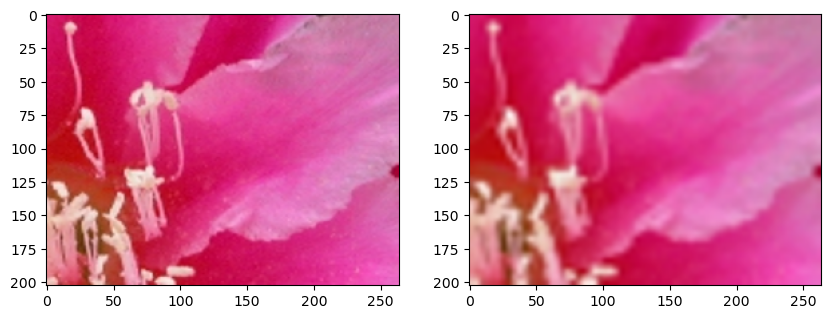

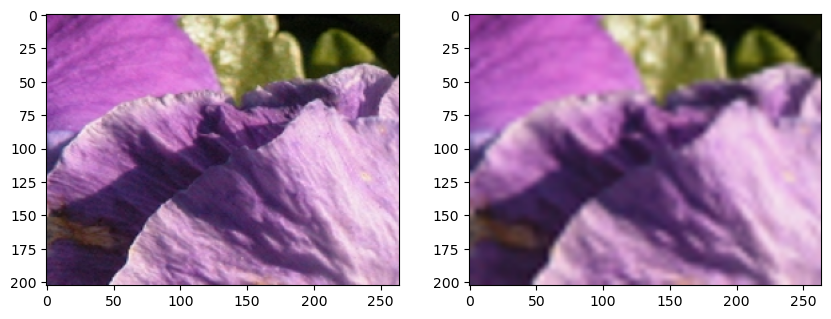

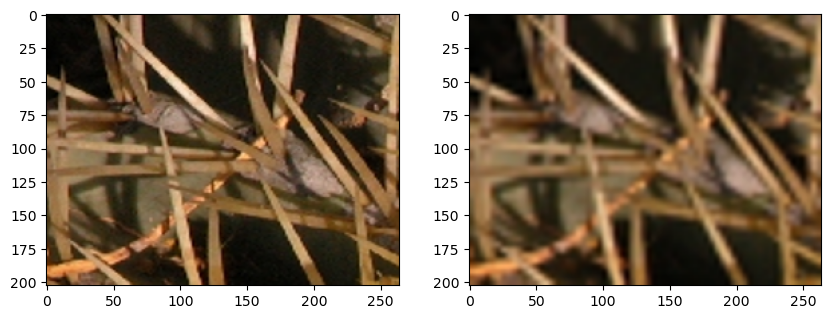

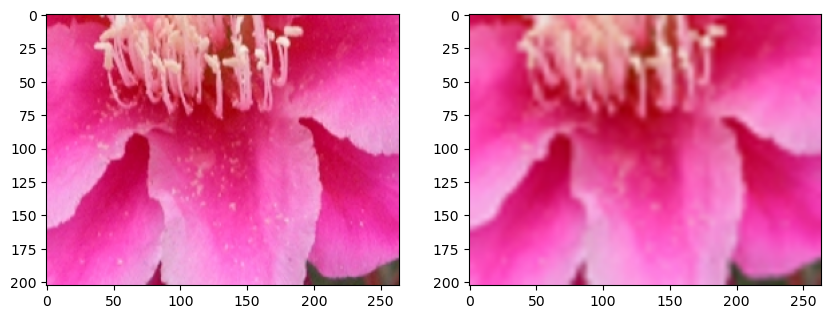

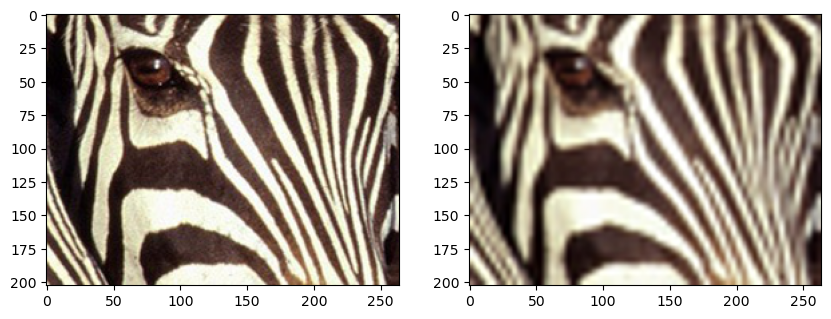

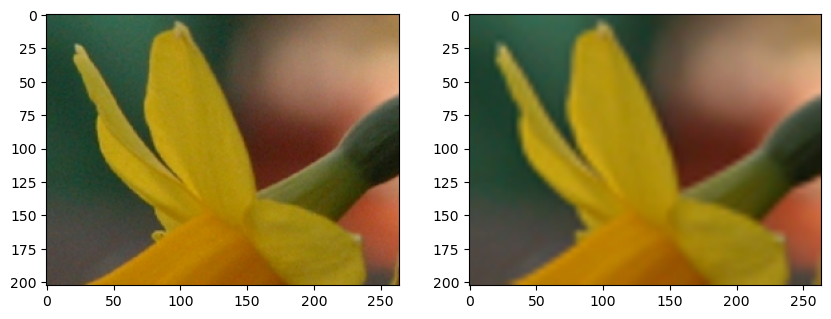

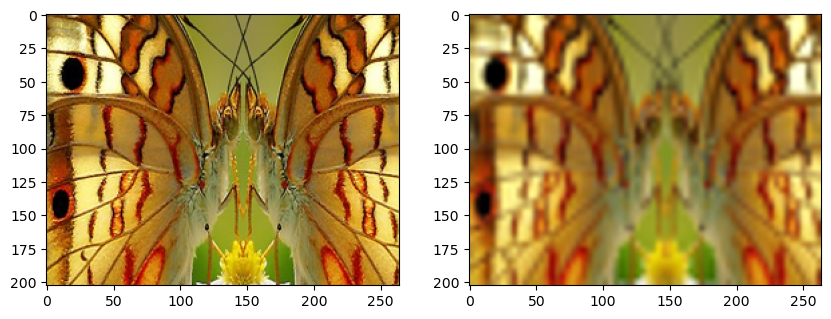

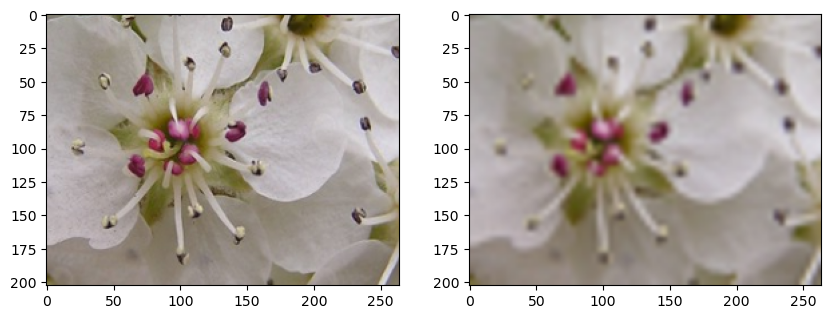

In [304]:
def train_imgs_visualization():
    for imgs in train:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        
        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)

def val_imgs_visualization():
    for imgs in train:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        
        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)

train_imgs_visualization()

## GPU

In [305]:
print('Pytorch CUDA Version is ', torch.version.cuda)

Pytorch CUDA Version is  11.3


In [306]:
print('Whether CUDA is supported by our system:', torch.cuda.is_available())

Whether CUDA is supported by our system: True


In [307]:
cuda_id = torch.cuda.current_device()
print('CUDA Device ID: ', torch.cuda.current_device())
print('Name of the current CUDA Device: ', torch.cuda.get_device_name(cuda_id))

CUDA Device ID:  0
Name of the current CUDA Device:  Quadro T2000 with Max-Q Design


In [308]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Instantiate the TrainFSRCNN class
model = FSRCNN(scale_factor = 2).to(device)
criterion = nn.MSELoss() 
optimizer =  optim.Adam(model.parameters(), lr = 1e-3) 
train_fsrcnn = TrainFSRCNN(model, criterion, optimizer, train, val, n_epochs = 50)

# Start training
train_fsrcnn.train()

C:\Users\moreiran\AppData\Local\Temp\ipykernel_22316\2754717010.py:12: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  hr_img = img.resize(hr_size, resample=Image.BICUBIC)
C:\Users\moreiran\AppData\Local\Temp\ipykernel_22316\2754717010.py:14: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_img = hr_img.resize((hr_size[0] // self.upscale_factor, hr_size[1] // self.upscale_factor), resample=Image.BICUBIC)


Epoch: 1, Loss: 0.141, Validation Loss: 0.092
Epoch: 2, Loss: 0.079, Validation Loss: 0.072
Epoch: 3, Loss: 0.072, Validation Loss: 0.073
Epoch: 4, Loss: 0.066, Validation Loss: 0.065
Epoch: 5, Loss: 0.046, Validation Loss: 0.043
Epoch: 6, Loss: 0.038, Validation Loss: 0.037
Epoch: 7, Loss: 0.027, Validation Loss: 0.029
Epoch: 8, Loss: 0.024, Validation Loss: 0.031
Epoch: 9, Loss: 0.024, Validation Loss: 0.029
Epoch: 10, Loss: 0.027, Validation Loss: 0.030
Epoch: 11, Loss: 0.025, Validation Loss: 0.026
Epoch: 12, Loss: 0.023, Validation Loss: 0.028
Epoch: 13, Loss: 0.024, Validation Loss: 0.026
Epoch: 14, Loss: 0.020, Validation Loss: 0.026
Epoch: 15, Loss: 0.021, Validation Loss: 0.024
Epoch: 16, Loss: 0.021, Validation Loss: 0.023
Epoch: 17, Loss: 0.018, Validation Loss: 0.019
Epoch: 18, Loss: 0.016, Validation Loss: 0.015
Epoch: 19, Loss: 0.014, Validation Loss: 0.015
Epoch: 20, Loss: 0.013, Validation Loss: 0.013
Epoch: 21, Loss: 0.013, Validation Loss: 0.014
Epoch: 22, Loss: 0.013